In [1]:
import jax
import numpyro
import numpy as np
import matplotlib.pyplot as plt
import numpyro_ext
#import numpyro.distributions as dist
#import numpyro_ext.distributions as distx, numpyro_ext.optim as optimx
import arviz as az
import corner
#import itertools
import scipy
import jax.numpy as jnp
import pandas as pd 
from jaxoplanet.orbits.keplerian import Central
from jaxoplanet.starry.surface import Surface
from jaxoplanet.starry.orbit import SurfaceSystem
import astropy.constants as const
%matplotlib widget

from collections.abc import Callable
from functools import partial
from jaxoplanet.starry.orbit import SurfaceSystem
from jaxoplanet.orbits.keplerian import Central, Body
from jaxoplanet.types import Array, Scalar
from jaxoplanet.core.limb_dark import light_curve as _limb_dark_light_curve
from jaxoplanet.starry.core.basis import A1, A2_inv, U
from jaxoplanet.starry.core.polynomials import Pijk
from jaxoplanet.starry.core.rotation import left_project
from jaxoplanet.starry.core.solution import rT, solution_vector
from jaxoplanet.starry.surface import Surface 

# For multi-core parallelism (useful when running multiple MCMC chains in parallel)
numpyro.set_host_device_count(2)

# For CPU (use "gpu" for GPU)
numpyro.set_platform("cpu")

# For 64-bit precision since JAX defaults to 32-bit
jax.config.update("jax_enable_x64", True)

h = 6.62607015e-34  # Planck constant [J*s]
c = 2.99792458e8    # speed of light [m/s]
kB = 1.380649e-23   # Boltzmann constant [J/K]

In [2]:
def planck(lamb_m, T):
    """Planck function B_lambda in SI units."""
    a = 2*h*c**2 / (lamb_m**5)
    b = h*c / (lamb_m*kB*T)
    return a / (jnp.exp(b) - 1)

def surface_light_curve(
    surface: Surface,
    r: float | None = None,
    x: float | None = None,
    y: float | None = None,
    z: float | None = None,
    theta: float | None = None,
    order: int = 20,
    higher_precision: bool = False,
):
    """Light curve of an occulted surface.

    Args:
        surface (Surface): Surface object
        r (float or None): radius of the occulting body, relative to the current map
           body
        x (float or None): x coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        y (float or None): y coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        z (float or None): z coordinate of the occulting body relative to the surface
           center. By default (None) 0.0
        theta (float):
            rotation angle of the map, in radians. By default 0.0
        order (int):
            order of the P integral numerical approximation. By default 20
        higher_precision (bool): whether to compute change of basis matrix as hight
            precision. By default False (only used to testing).

    Returns:
        ArrayLike: flux
    """
    if higher_precision:
        try:
            from jaxoplanet.starry.multiprecision import (
                basis as basis_mp,
                utils as utils_mp,
            )
        except ImportError as e:
            raise ImportError(
                "The `mpmath` Python package is required for higher_precision=True."
            ) from e

    total_deg = surface.deg

    rT_deg = rT(total_deg)

    x = 0.0 if x is None else x
    y = 0.0 if y is None else y
    z = 0.0 if z is None else z

    # no occulting body
    if r is None:
        b_rot = True
        theta_z = 0.0
        design_matrix_p = rT_deg

    # occulting body
    else:
        b = jnp.sqrt(jnp.square(x) + jnp.square(y))
        b_rot = jnp.logical_or(jnp.greater_equal(b, 1.0 + r), jnp.less_equal(z, 0.0))
        b_occ = jnp.logical_not(b_rot)

        # trick to avoid nan `x=jnp.where...` grad caused by nan sT
        r = jnp.where(b_rot, 1.0, r)
        b = jnp.where(b_rot, 1.0, b)

        if surface.ydeg == 0:
            if surface.udeg == 0:
                ld_u = jnp.array([])
            else:
                ld_u = jnp.concatenate(
                    [jnp.atleast_1d(jnp.asarray(u_)) for u_ in surface.u], axis=0
                )

            lc_func = partial(_limb_dark_light_curve, ld_u, order=order)
            lc = lc_func(b, r)
            return surface.amplitude * (1.0 + jnp.where(b_occ, lc, 0))

        else:
            theta_z = jnp.arctan2(x, y)
            sT = solution_vector(total_deg, order=order)(b, r)

        if total_deg > 0:
            if higher_precision:
                A2 = np.atleast_2d(utils_mp.to_numpy(basis_mp.A2(total_deg)))
            else:
                A2 = scipy.sparse.linalg.inv(A2_inv(total_deg))
                A2 = jax.experimental.sparse.BCOO.from_scipy_sparse(A2)
        else:
            A2 = jnp.array([[1]])

        design_matrix_p = jnp.where(b_occ, sT @ A2, rT_deg)

    if surface.ydeg == 0:
        rotated_y = surface.y.todense()
    else:
        rotated_y = left_project(
            surface.ydeg,
            surface._inc,
            surface._obl,
            theta,
            theta_z,
            surface.y.todense(),
        )

    # limb darkening
    if surface.udeg == 0:
        p_u = Pijk.from_dense(jnp.array([1]))
    else:
        u = jnp.array([1, *surface.u])
        p_u = Pijk.from_dense(u @ U(surface.udeg), degree=surface.udeg)

    # surface map * limb darkening map
    if higher_precision:
        A1_val = np.atleast_2d(utils_mp.to_numpy(basis_mp.A1(surface.ydeg)))
    else:
        A1_val = jax.experimental.sparse.BCOO.from_scipy_sparse(A1(surface.ydeg))

    p_y = Pijk.from_dense(A1_val @ rotated_y, degree=surface.ydeg)
    p_yu = p_y * p_u
    norm = np.pi / (p_u.tosparse() @ rT(surface.udeg))

    return surface.amplitude * (p_yu.tosparse() @ design_matrix_p) * norm

def system_observable(surface_observable, flux_planet, flux_star, **kwargs):
    _surface_observable = partial(surface_observable, **kwargs)

    def observable_fun(
        system: SurfaceSystem,
    ) -> Callable[[Scalar], tuple[Array | None, Array | None]]:
        # the observable function of the central given the position and radii
        # of all other bodies
        central_bodies_observable = jax.vmap(
            _surface_observable, in_axes=(None, 0, 0, 0, 0, None)
        )

        # the observable function of all bodies combined given their position to the
        # central
        @partial(system.surface_vmap, in_axes=(0, 0, 0, 0, None))
        def compute_body_observable(surface, radius, x, y, z, time):
            if surface is None:
                return 0.0
            else:
                theta = surface.rotational_phase(time)
                return _surface_observable(
                    surface,
                    (system.central.radius / radius),
                    (x / radius),
                    (y / radius),
                    (z / radius),
                    theta,
                )

        @partial(jnp.vectorize, signature="()->(n)")
        def observable_impl(time: Scalar) -> Array:
            # a function that give the array of observables for all bodies, starting
            # with the central
            if system.central_surface is None:
                central_light_curves = jnp.array([0.0])
            else:
                theta = system.central_surface.rotational_phase(time)
                central_radius = system.central.radius
                central_phase_curve = _surface_observable(
                    system.central_surface, theta=theta
                )
                if len(system.bodies) > 0:
                    xos, yos, zos = system.relative_position(time)
                    n = len(xos)
                    central_light_curves = central_bodies_observable(
                        system.central_surface,
                        (system.radius / central_radius),
                        (xos / central_radius),
                        (yos / central_radius),
                        (zos / central_radius),
                        theta,
                    )
                    def phase_planet(time,P,t0=0):
                        phase = jnp.sin(((time+t0)/P)*2*jnp.pi - jnp.pi/2)/2+0.5 
                        return phase
                    if n > 1 and central_light_curves is not None:
                        central_light_curves = central_light_curves.sum(
                            0
                        ) - central_phase_curve * (n - 1)
                        central_light_curves = jnp.expand_dims(central_light_curves, 0)

                    body_light_curves = compute_body_observable(
                        system.radius, -xos, -yos, -zos, time
                    )
                    in_eclipse = jnp.logical_not(body_light_curves)
                    body_light_curves_2 = (flux_planet/flux_star)*phase_planet(time,system.bodies[0].period)*(system.bodies[0].radius/system.central.radius)**2 * (-1*in_eclipse+1) 
                    #body_light_curves_2 = body_light_curves_2/jnp.max(body_light_curves_2)
                    return jnp.hstack([central_light_curves, body_light_curves_2])
                else:
                    return jnp.array([central_phase_curve])

        return observable_impl

    return observable_fun

def light_curve(system, flux_planet, flux_star, order=20):
    return system_observable(surface_light_curve, flux_planet, flux_star, order=order)(system)

In [3]:
def fast_binning(x, y, bins, error=None, std=False):
    bins = np.arange(np.min(x), np.max(x), bins)
    d = np.digitize(x, bins)

    n = np.max(d) + 2

    binned_x = np.empty(n)
    binned_y = np.empty(n)
    binned_error = np.empty(n)

    binned_x[:] = -np.pi
    binned_y[:] = -np.pi
    binned_error[:] = -np.pi

    for i in range(0, n):
        s = np.where(d == i)
        if len(s[0]) > 0:
            s = s[0]
            binned_y[i] = np.mean(y[s])
            binned_x[i] = np.mean(x[s])
            binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

            if error is not None:
                err = error[s]
                binned_error[i] = np.sqrt(np.sum(np.power(err, 2))) / len(err)
            else:
                binned_error[i] = np.std(y[s]) / np.sqrt(len(s))

    nans = binned_x == -np.pi
    
    return binned_x[~nans], binned_y[~nans], binned_error[~nans]

In [4]:
df = pd.read_pickle("LHS3844b_0.0_1obs.pickle")
wvl = df['data'].keys()

df2 = pd.read_pickle("K2-141b_phase_curve_max_1obs.pickle")
print(df2)
print(df2['datasets'].keys())

P=df2['theta'][3]
R_star = df2['theta'][0]
M_star = df2['theta'][2]
time_transit = df2['theta'][4]
r = df2['theta'][6]
R = df2['theta'][6]*R_star
#print(R)
T_star = df2['theta'][1]
T_planet = df2['theta'][8]
#print(T_planet)
uu = np.array([0.45, 0.05]) # Quadratic limb-darkening coefficients

def light_curve_model(time, lamb, R, T_planet, T_star, P, R_star, M_star, time_transit, uu): # light_curve_model(time, time_transit, P, R_star, M_star, R, T_star, T_planet, uu)
    star = Central(radius=R_star, mass=M_star)
    planet = Body(radius=R, time_transit=0, period=P)
    m = Surface(u=uu)
    system = SurfaceSystem(star, m).add_body(planet, m)
    flux_star = planck(lamb*1e-6, jnp.mean(T_star))
    flux_planet = planck(lamb*1e-6, jnp.mean(T_planet))
    pc = light_curve(system, flux_planet, flux_star)(time)[:,1] + light_curve(system, flux_planet, flux_star)(time)[:,0]
    #pc = pc/np.max(pc)
    return pc

instru = df2['datasets'].keys()
instru = list(instru)
instru.pop(0)

{'datasets': {'VISPhot': {'exp_time': np.float64(15.486649361674086), 'min_wl': np.float64(0.5), 'max_wl': np.float64(0.6000000000000001), 'dead_time': 0.2, 'model_time': 900.0, 'lc':               time     phase  ref_pc  therm_pc  transit     model  flux_error  \
0     2.457744e+06  0.806803       0  0.000001      0.0  1.000001    0.001604   
1     2.457744e+06  0.810873       0  0.000001      0.0  1.000001    0.001604   
2     2.457744e+06  0.814942       0  0.000001      0.0  1.000001    0.001604   
3     2.457744e+06  0.819011       0  0.000001      0.0  1.000001    0.001604   
4     2.457744e+06  0.823081       0  0.000001      0.0  1.000001    0.001604   
...            ...       ...     ...       ...      ...       ...         ...   
2687  2.457745e+06  5.458228       0  0.000001      0.0  1.000001    0.001604   
2688  2.457745e+06  5.462298       0  0.000001      0.0  1.000001    0.001604   
2689  2.457745e+06  5.466367       0  0.000001      0.0  1.000001    0.001604   
2690  

'VISPhot'

In [5]:
print(type(df2))
print(len(df2))
print(df2.keys())
print(df2['parameters'])
print(df2['pl_type'])
print(df2['theta'])
print(df2['num_obs'])
print(df2['datasets']['AIRS-CH1'])
print(df2['datasets']['VISPhot']['lc'])

instru = df2['datasets'].keys()
print(instru)
instru = list(instru)
instru.pop(0)

plt.rcParams.update({
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
})

dataset = {}
for i, inst in enumerate(instru) : 
    time = df2['datasets'][inst]['lc']['time'] - time_transit
    pc = df2['datasets'][inst]['lc']['model']
    dataset[list(wvl)[i]] = [time, df2['datasets'][inst]['lc']['ariel'], df2['datasets'][inst]['lc']['flux_error']]
    second_binned = fast_binning(time, df2['datasets'][inst]['lc']['ariel'], 0.01, error = np.array(df2['datasets'][inst]['lc']['flux_error']))
    """plt.figure()
    plt.errorbar(time, df2['datasets'][inst]['lc']['ariel'], yerr=df2['datasets'][inst]['lc']['flux_error'], c=(1, 1, 0.2), fmt='.', label='data')
    plt.errorbar(second_binned[0], second_binned[1], yerr=second_binned[2], c=(1, 0.5, 0), fmt='o', label='data binned', zorder=3)
    plt.plot(time, light_curve_model(time, list(wvl)[i], R, T_planet, T_star, P, R_star, M_star, time_transit, uu), label='our model', zorder=10)
    plt.plot(time, pc, 'k', label='origin data', zorder=5)
    plt.title(rf'Phase curve at $\lambda$ = {list(wvl)[i]} $\mu$m with {str(inst)}', fontsize=16)
    plt.legend(fontsize=12)
    plt.xlabel(fr'BJD - {time_transit} [d]', fontsize=14)
    plt.ylabel(r'$(F_p + F_{\bigstar})/F_{\bigstar}$', fontsize=14)
    plt.savefig(f"model_K2-141b{str(inst)}.svg")
    plt.show()"""


<class 'dict'>
5
dict_keys(['datasets', 'pl_type', 'parameters', 'theta', 'num_obs'])
{'Rs': {'index': 0}, 'Ts': {'index': 1}, 'Ms': {'index': 2}, 'P': {'index': 3}, 'T0': {'index': 4}, 'i': {'index': 5}, 'Rp/Rs': {'index': 6}, 'HSO': {'index': 7}, 'Td': {'index': 8}, 'Tn': {'index': 9}, 'A_g': {'index': 10}}
max
[6.74000000e-01 4.37300000e+03 6.62000000e-01 2.80324400e-01
 2.45774407e+06 9.00000000e+01 2.08800000e-02 0.00000000e+00
 2.61443829e+03 5.00000000e+01 0.00000000e+00]
1
{'exp_time': np.float64(26.869994367102755), 'min_wl': np.float64(3.9), 'max_wl': np.float64(8.023322839739118), 'dead_time': 0.2, 'model_time': 900.0, 'lc':               time     phase  ref_pc  therm_pc  transit     model  flux_error  \
0     2.457744e+06  0.806803       0  0.000031      0.0  1.000031    0.000689   
1     2.457744e+06  0.813826       0  0.000032      0.0  1.000032    0.000689   
2     2.457744e+06  0.820848       0  0.000032      0.0  1.000032    0.000689   
3     2.457744e+06  0.827871    

In [6]:
2/(60*24)

0.001388888888888889

In [7]:
print(dataset[5.96][2])

0       0.000689
1       0.000689
2       0.000689
3       0.000689
4       0.000689
          ...   
1555    0.000689
1556    0.000689
1557    0.000689
1558    0.000689
1559    0.000689
Name: flux_error, Length: 1560, dtype: float64


In [8]:
def mcmc(lamb, P, R_star, M_star, time_transit, R_planet, T_star, T_planet, uu):
        time = dataset[lamb][0]
        observed = dataset[lamb][1]
        yerr_array = dataset[lamb][2]
        yerr = dataset[lamb][2][0]
        def MCMC_model(time, yerr, y=None):
            # Priors for the parameters we're fitting for

            # The radius of the planet
            r = numpyro.sample("r", numpyro.distributions.Normal(R_planet, 0.01))

            # The radius of the star
            R_star_prior = numpyro.sample("R_star", numpyro.distributions.Normal(R_star, 0.05))

            # The mass of the star
            M_star_prior = numpyro.sample("M_star", numpyro.distributions.Normal(M_star, 0.02))

            # The star temperature
            T_star_prior = numpyro.sample("T_star", numpyro.distributions.Normal(T_star, 10))

            # The planet temperature
            T_planet_prior = numpyro.sample("T_planet", numpyro.distributions.Normal(T_planet, 200))

            u1 = numpyro.sample("u1", numpyro.distributions.Normal(uu[0], 0.2))

            u2 = numpyro.sample("u2", numpyro.distributions.Normal(uu[1], 0.2))

            # The orbit and light curve
            y_pred = light_curve_model(time, lamb, r, T_planet_prior, T_star_prior, P, R_star_prior, M_star_prior, time_transit, (u1, u2))

            # Let's track the light curve
            numpyro.deterministic("light_curve", y_pred)

            # The likelihood function assuming Gaussian uncertainty
            numpyro.sample("obs", numpyro.distributions.Normal(y_pred, yerr), obs=y)

        n_prior_samples = 3000
        prior_samples = numpyro.infer.Predictive(MCMC_model, num_samples=n_prior_samples)(jax.random.PRNGKey(0), time, yerr)

        # Let's make it into an arviz InferenceData object.
        # To do so we'll first need to reshape the samples to be of shape (chains, draws, *shape)
        converted_prior_samples = {
            f"{p}": np.expand_dims(prior_samples[p], axis=0) for p in prior_samples
        }
        prior_samples_inf_data = az.from_dict(converted_prior_samples)
        fig = plt.figure(figsize=(12, 12))
        _ = corner.corner(
            prior_samples_inf_data,
            fig=fig,
            var_names=["r", "T_planet", "T_star", "M_star", "R_star", "u1", "u2"],
            truths=[R_planet, T_planet, T_star, M_star, R_star, uu[0], uu[1]],
            show_titles=True,
            title_kwargs={"fontsize": 10},
            label_kwargs={"fontsize": 10},
        )
        plt.savefig(f"priors_{str(lamb)}.svg")
        init_param_method = "true_values"  # "prior_median" or "true_values"

        if init_param_method == "prior_median":
            print("Starting from the prior medians")
            run_optim = numpyro_ext.optim.optimize(
                MCMC_model, init_strategy=numpyro.infer.init_to_median()
            )
        elif init_param_method == "true_values":
            print("Starting from the true values")
            init_params = {
                #"t0": float(time_transit),
                #"logP": jnp.log(P),
                "r": R_planet,
                #"logM": jnp.log(M_star),
                "M_star" : float(M_star),
                "R_star" : float(R_star),
                "T_star" : float(T_star),
                "T_planet" : float(T_planet),
                "u1": uu[0],
                "u2": uu[1],
            }
            run_optim = numpyro_ext.optim.optimize(
                MCMC_model,
                init_strategy=numpyro.infer.init_to_value(values=init_params),
            )

        time = jnp.asarray(time, dtype=jnp.float64)
        yerr = jnp.asarray(yerr, dtype=jnp.float64)
        observed = jnp.asarray(observed, dtype=jnp.float64)

        opt_params = run_optim(jax.random.PRNGKey(3), time, yerr, y=observed)
        for k, v in opt_params.items():
            if k in ["light_curve", "obs"]:
                continue
            print(f"optimized value of {k}: {v}")
        sampler = numpyro.infer.MCMC(
        numpyro.infer.NUTS(
            MCMC_model,
            dense_mass=True,
            regularize_mass_matrix=True,
            init_strategy=numpyro.infer.init_to_value(values=opt_params),
        ),
        num_warmup=500,
        num_samples=1000,
        num_chains=1,
        progress_bar=True,
        )

        sampler.run(jax.random.PRNGKey(1), time, yerr, y=observed)
        inf_data = az.from_numpyro(sampler)
        fig = plt.figure(figsize=(12, 12))
        _ = corner.corner(
            inf_data,
            var_names=["r", "T_planet", "R_star", "M_star", "T_star", "u1", "u2"],
            truths=[R, T_planet, R_star, M_star, T_star, uu[0], uu[1]],
            show_titles=True,
            quantiles=[0.16, 0.5, 0.84],
            title_kwargs={"fontsize": 10},
            label_kwargs={"fontsize": 10},
            title_fmt=".10f",
            fig=fig,
        )
        plt.savefig(f"posteriors_{str(lamb)}.svg")
        samples = sampler.get_samples()
        r_percentiles = np.percentile(samples["r"], [16, 50, 84], axis=0)
        r_minus = r_percentiles[1]-r_percentiles[0]
        r_plus = r_percentiles[2]-r_percentiles[1]
        R_mcmc = r_percentiles[1]
        R_star_percentiles = np.percentile(samples["R_star"], [16, 50, 84], axis=0)
        R_star_minus = R_star_percentiles[1]-R_star_percentiles[0]
        R_star_plus = R_star_percentiles[2]-R_star_percentiles[1]
        R_star_mcmc = R_star_percentiles[1]
        M_star_percentiles = np.percentile(samples["M_star"], [16, 50, 84], axis=0)
        M_star_minus = M_star_percentiles[1]-M_star_percentiles[0]
        M_star_plus = M_star_percentiles[2]-M_star_percentiles[1]
        M_star_mcmc = M_star_percentiles[1]
        T_percentiles = np.percentile(samples["T_planet"], [16, 50, 84], axis=0)
        T_minus = T_percentiles[1]-T_percentiles[0]
        T_plus = T_percentiles[2]-T_percentiles[1]
        T_mcmc = T_percentiles[1]
        T_star_percentiles = np.percentile(samples["T_star"], [16, 50, 84], axis=0)
        T_star_minus = T_star_percentiles[1]-T_star_percentiles[0]
        T_star_plus = T_star_percentiles[2]-T_star_percentiles[1]
        T_star_mcmc = T_star_percentiles[1]
        u1_percentiles = np.percentile(samples["u1"], [16, 50, 84], axis=0)
        u1_minus = u1_percentiles[1]-u1_percentiles[0]
        u1_plus = u1_percentiles[2]-u1_percentiles[1]
        u1_mcmc = u1_percentiles[1]
        u2_percentiles = np.percentile(samples["u2"], [16, 50, 84], axis=0)
        u2_minus = u2_percentiles[1]-u2_percentiles[0]
        u2_plus = u2_percentiles[2]-u2_percentiles[1]
        u2_mcmc = u2_percentiles[1]

        plt.figure()
        plt.plot(time, light_curve_model(time, lamb, R_planet, T_planet, T_star, P, R_star, M_star, time_transit, uu), label='truth', zorder=3)
        plt.plot(time, light_curve_model(time, lamb, R_mcmc, T_mcmc, T_star_mcmc, P, R_star_mcmc, M_star_mcmc, time_transit, (u1_mcmc, u2_mcmc)), "--C0", label="MCMC result", zorder=3)
        plt.errorbar(time, observed, yerr=yerr_array, fmt='o', label='data')
        plt.title(rf'Phase curve at $\lambda$ = {lamb} $\mu$m')
        plt.legend()
        plt.xlabel(r'BJD$_{TDB}$ - 2,458,829 [d]')
        plt.ylabel(r'$\frac{F_p + F_{\star}}{F_{\star}}$')
        plt.show()
        data = jnp.array([[r_minus, r_plus, R_mcmc], [T_minus, T_plus, T_mcmc], [T_star_minus, T_star_plus, T_star_mcmc], [R_star_minus, R_star_plus, R_star_mcmc], [M_star_minus, M_star_plus, M_star_mcmc],
                          [u1_minus, u1_plus, u1_mcmc], [u2_minus, u2_plus, u2_mcmc]])
        np.savetxt(f"result_mcmc_{lamb}.txt", data, fmt="%.2f", delimiter="\t", header="16th percentile\t84th percentile\t50th percentile")

        return data

In [9]:
"""radii = [np.float64(0.011914195169255754), np.float64(0.011796041281380867), np.float64(0.011691259589179617), np.float64(0.011898263112785608), np.float64(0.011835223562172197)]
radii_plus = [np.float64(0.0001822338110646811), np.float64(9.667810361068015e-05), np.float64(0.0001423261797635668), np.float64(0.00019669422060385536), np.float64(0.00019360349868962137)]
radii_minus = [np.float64(0.00016810548354498876), np.float64(8.708184510037957e-05), np.float64(0.0001500186657301672), np.float64(0.00019883316569517182), np.float64(0.00018110870101775006)]
Temps = [np.float64(1044.5190585111627), np.float64(1055.6954729682202), np.float64(1058.0927917878525), np.float64(1037.3815062163017), np.float64(970.1929118824233)]
Temps_plus = [np.float64(189.97345054412312), np.float64(109.20526779618831), np.float64(50.0002065899414), np.float64(37.68081802464553), np.float64(27.011632602612735)]
Temps_minus = [np.float64(205.30095043547476), np.float64(157.83733685518519), np.float64(48.4122201942763), np.float64(35.023239885232215), np.float64(22.449475656927007)]
Temps_star = [np.float64(3036.834013017712), np.float64(3036.7930858115415), np.float64(3036.6045201111997), np.float64(3036.748008227609), np.float64(3036.930845055757)]
Temps_star_plus = [np.float64(8.89487518969645), np.float64(9.786958942350793), np.float64(8.978435972698662), np.float64(9.307017967107186), np.float64(9.166163788814174)]
Temps_star_minus = [np.float64(9.981885711566974), np.float64(10.02696506940265), np.float64(9.724656769962166), np.float64(9.932705207935214), np.float64(9.14251390065283)]
u1 = [np.float64(0.4688509901347141), np.float64(0.4396391912141232), np.float64(0.4925688525859919), np.float64(0.4571148949593108), np.float64(0.4459885907077925)]
u1_plus = [np.float64(0.12077856391508146), np.float64(0.09082760811288271), np.float64(0.10596342095138045), np.float64(0.12036137838156258), np.float64(0.13413841946401683)]
u1_minus = [np.float64(0.12912837052067616), np.float64(0.09551490404125274), np.float64(0.12106067252512992), np.float64(0.13754742486219962), np.float64(0.12636392346890418)]
u2 = [np.float64(0.11321556350332176), np.float64(0.15233183479349993), np.float64(0.15403862582969474), np.float64(0.07762102026640903), np.float64(0.06541745664451129)]
u2_plus = [np.float64(0.1685010559255851), np.float64(0.14221688874115634), np.float64(0.1550661943163808), np.float64(0.17642476266031143), np.float64(0.16736816004693195)]
u2_minus = [np.float64(0.1668266986141934), np.float64(0.14112432132909267), np.float64(0.15958422615713844), np.float64(0.1794550705615212), np.float64(0.16979806147638182)]"""

'radii = [np.float64(0.011914195169255754), np.float64(0.011796041281380867), np.float64(0.011691259589179617), np.float64(0.011898263112785608), np.float64(0.011835223562172197)]\nradii_plus = [np.float64(0.0001822338110646811), np.float64(9.667810361068015e-05), np.float64(0.0001423261797635668), np.float64(0.00019669422060385536), np.float64(0.00019360349868962137)]\nradii_minus = [np.float64(0.00016810548354498876), np.float64(8.708184510037957e-05), np.float64(0.0001500186657301672), np.float64(0.00019883316569517182), np.float64(0.00018110870101775006)]\nTemps = [np.float64(1044.5190585111627), np.float64(1055.6954729682202), np.float64(1058.0927917878525), np.float64(1037.3815062163017), np.float64(970.1929118824233)]\nTemps_plus = [np.float64(189.97345054412312), np.float64(109.20526779618831), np.float64(50.0002065899414), np.float64(37.68081802464553), np.float64(27.011632602612735)]\nTemps_minus = [np.float64(205.30095043547476), np.float64(157.83733685518519), np.float64(48

In [10]:
print(instru)

['FGS1', 'FGS2', 'NIRSpec', 'AIRS-CH0-bin1', 'AIRS-CH0-bin2', 'AIRS-CH1']


In [11]:
radii = []
radii_plus = []
radii_minus = []
Temps = []
Temps_plus = []
Temps_minus = []
Temps_star = []
Temps_star_plus = []
Temps_star_minus = []
Radii_star = []
Radii_star_plus = []
Radii_star_minus = []
Masses_star = []
Masses_star_plus = []
Masses_star_minus = []
u1 = []
u1_plus = []
u1_minus = []
u2 = []
u2_plus = []
u2_minus = []
for i in list(wvl):
    data = np.loadtxt(f"result_mcmc_K2-141b_{i}.txt")
    radii.append(data[0][2])
    radii_plus.append(data[0][1])
    radii_minus.append(data[0][0])
    Temps.append(data[1][2])
    Temps_plus.append(data[1][1])
    Temps_minus.append(data[1][0])
    Temps_star.append(data[2][2])
    Temps_star_plus.append(data[2][1])
    Temps_star_minus.append(data[2][0])
    Radii_star.append(data[3][2])
    Radii_star_plus.append(data[3][1])
    Radii_star_minus.append(data[3][0])
    Masses_star.append(data[4][2])
    Masses_star_plus.append(data[4][1])
    Masses_star_minus.append(data[4][0])
    u1.append(data[5][2])
    u1_plus.append(data[5][1])
    u1_minus.append(data[5][0])
    u2.append(data[6][2])
    u2_plus.append(data[6][1])
    u2_minus.append(data[6][0])
    
"""for i, inst in enumerate(instru) : 
    print(i)
    print(inst)
    time = df2['datasets'][inst]['lc']['time'] - time_transit
    pc = df2['datasets'][inst]['lc']['model']
    plt.figure()
    plt.errorbar(time, df2['datasets'][inst]['lc']['ariel'], yerr=df2['datasets'][inst]['lc']['flux_error'], c=(1, 1, 0.2), fmt='.', label='data')
    plt.plot(time, light_curve_model(time, list(wvl)[i], R, T_planet, T_star, P, R_star, M_star, time_transit, uu), label='our model', zorder=10)
    plt.plot(time, light_curve_model(time, list(wvl)[i], radii[i], Temps[i], Temps_star[i], P, R_star, M_star, time_transit, (u1[i], u2[i])), "--C0", label="MCMC result", zorder=5)
    plt.plot(time, pc, 'k', label='origin data', zorder=3)
    plt.title(rf'Phase curve at $\lambda$ = {list(wvl)[i]} $\mu$m with {str(inst)}', fontsize=16)
    plt.legend(fontsize=12)
    plt.xlabel(r'BJD$_{TDB}$ - 2,458,829 [d]', fontsize=14)
    plt.ylabel(r'$(F_p + F_{\bigstar})/F_{\bigstar}$', fontsize=14)
    plt.savefig(f"mcmc_K2-141b_{str(inst)}.svg")
    plt.show()"""

'for i, inst in enumerate(instru) : \n    print(i)\n    print(inst)\n    time = df2[\'datasets\'][inst][\'lc\'][\'time\'] - time_transit\n    pc = df2[\'datasets\'][inst][\'lc\'][\'model\']\n    plt.figure()\n    plt.errorbar(time, df2[\'datasets\'][inst][\'lc\'][\'ariel\'], yerr=df2[\'datasets\'][inst][\'lc\'][\'flux_error\'], c=(1, 1, 0.2), fmt=\'.\', label=\'data\')\n    plt.plot(time, light_curve_model(time, list(wvl)[i], R, T_planet, T_star, P, R_star, M_star, time_transit, uu), label=\'our model\', zorder=10)\n    plt.plot(time, light_curve_model(time, list(wvl)[i], radii[i], Temps[i], Temps_star[i], P, R_star, M_star, time_transit, (u1[i], u2[i])), "--C0", label="MCMC result", zorder=5)\n    plt.plot(time, pc, \'k\', label=\'origin data\', zorder=3)\n    plt.title(rf\'Phase curve at $\\lambda$ = {list(wvl)[i]} $\\mu$m with {str(inst)}\', fontsize=16)\n    plt.legend(fontsize=12)\n    plt.xlabel(r\'BJD$_{TDB}$ - 2,458,829 [d]\', fontsize=14)\n    plt.ylabel(r\'$(F_p + F_{\x08igst

In [22]:
transit_depths_jax = []
transit_depths_jax_plus = []
transit_depths_jax_minus = []
transit_depths_jax_init = []
for i, inst in enumerate(instru) : 
    print(i)
    print(inst)
    time = df2['datasets'][inst]['lc']['time'] - time_transit - P
    #print(np.where(np.abs(time) <= 1e-3))
    pc_init = light_curve_model(time, list(wvl)[i], R, T_planet, T_star, P, R_star, M_star, time_transit, uu)
    pc = light_curve_model(time, list(wvl)[i], radii[i], Temps[i], Temps_star[i], P, Radii_star[i], Masses_star[i], time_transit, (u1[i], u2[i]))
    pc_plus = light_curve_model(time, list(wvl)[i], radii[i] + radii_plus[i], Temps[i] + Temps_plus[i], Temps_star[i] + Temps_star_plus[i], P, 
                                Radii_star[i] + Radii_star_plus[i], Masses_star[i] + Masses_star_plus[i], time_transit, (u1[i] + u1_plus[i], u2[i] + u2_plus[i]))
    pc_minus = light_curve_model(time, list(wvl)[i], radii[i] - radii_minus[i], Temps[i] - Temps_minus[i], Temps_star[i] - Temps_star_minus[i], P, 
                                 Radii_star[i] - Radii_star_minus[i], Masses_star[i] - Masses_star_minus[i], time_transit, (u1[i] - u1_minus[i], u2[i] - u2_minus[i]))
    """plt.figure()
    plt.plot(time, pc, label='pc')
    plt.plot(time, pc_plus, label='pc plus')
    plt.plot(time, pc_minus, label='pc minus')
    plt.legend()
    plt.show()"""
    index_transit = np.where(np.abs(time) <= 1e-3)
    print((1 - pc[index_transit[0][0]])*1e6)
    transit_depths_jax.append(1 - pc[index_transit[0][0]])
    transit_depths_jax_plus.append(1 - pc_plus[index_transit[0][0]])
    transit_depths_jax_minus.append(1 - pc_minus[index_transit[0][0]])
    transit_depths_jax_init.append(1 - pc_init[index_transit[0][0]])
print(transit_depths_jax_plus)
print(transit_depths_jax_minus)

0
FGS1
463.319325149647
1
FGS2
536.056646932681
2
NIRSpec
571.7357000443179
3
AIRS-CH0-bin1
483.1917528793639
4
AIRS-CH0-bin2
494.0729943696542
5
AIRS-CH1
486.54304416673176
[Array(0.00057486, dtype=float64), Array(0.00061945, dtype=float64), Array(0.0006521, dtype=float64), Array(0.00054837, dtype=float64), Array(0.00057487, dtype=float64), Array(0.00057325, dtype=float64)]
[Array(0.00037946, dtype=float64), Array(0.00045845, dtype=float64), Array(0.00051031, dtype=float64), Array(0.00041413, dtype=float64), Array(0.00042347, dtype=float64), Array(0.00040036, dtype=float64)]


In [12]:
plt.close('all')

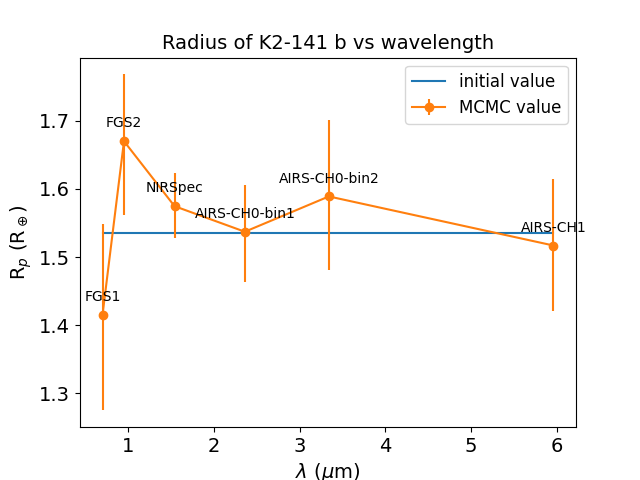

In [13]:
r_yerr = np.vstack((radii_minus, radii_plus))

plt.figure()
plt.plot(list(wvl), R*(const.R_sun/const.R_earth)*np.ones(len(list(wvl))), label='initial value')
plt.errorbar(list(wvl), radii*const.R_sun/const.R_earth, r_yerr*const.R_sun/const.R_earth, fmt='-o', label='MCMC value')
for i, (x_val, y_val) in enumerate(zip(list(wvl), radii*const.R_sun/const.R_earth)):
    plt.annotate(f'{str(instru[i])}',
                 (x_val, y_val),
                 textcoords="offset points",  # how to position the text
                 xytext=(0, 10),              # distance from the point
                 ha='center')                 # horizontal alignment
#plt.plot(wvl, radii*const.R_sun/const.R_earth)
#plt.fill_between(wvl, (np.array(radii) - np.array(radii_minus))*const.R_sun/const.R_earth, (np.array(radii) + np.array(radii_plus))*const.R_sun/const.R_earth, alpha=0.2)
plt.xlabel(r'$\lambda$ ($\mu$m)', fontsize=14)
plt.ylabel(r'R$_p$ (R$_\oplus$)', fontsize=14)
plt.legend(fontsize=12)
plt.title('Radius of K2-141 b vs wavelength', fontsize=14)
plt.savefig('radii_K2-141b.svg')
plt.show()

In [14]:
import astropy.units as u
import astropy.constants as const

a = 0.00747*149597870700
i = 86.3
e = 0
omega = 90
b = a/(R_star*const.R_sun.value) * np.cos(i) * (1-e**2)/(1+e*np.sin(omega))
print(b)
mu_0 = np.sqrt(1-b**2)
theta = np.linspace(0, np.pi/2, 100)
mu = np.cos(theta)
factor = []
factor_minus = []
factor_plus = []
factor_init = []
star_fluxes = []
star_fluxes_minus = []
star_fluxes_plus = []

def I(I1, mu, u1, u2):
        return I1 * (1 - u1*(1-mu) - u2*(1-mu)**2)

for i in range(len(instru)):
    star_fluxes.append(planck(list(wvl)[i]*1e-6, Temps_star[i]))
    #print(star_fluxes)
    star_fluxes_minus.append(planck(list(wvl)[i]*1e-6, Temps_star_minus[i]))
    #print(star_fluxes_minus)
    star_fluxes_plus.append(planck(list(wvl)[i]*1e-6, Temps_star_plus[i]))
    #print(star_fluxes_plus)
    I1 = star_fluxes[i]/(2*np.pi*(0.5 - u1[i]/6 - u2[i]/12))
    #print(I1)
    I1_minus = star_fluxes_minus[i]/(2*np.pi*(0.5 - u1_minus[i]/6 - u2_minus[i]/12))
    # print(I1_minus)
    I1_plus = star_fluxes_plus[i]/(2*np.pi*(0.5 - u1_plus[i]/6 - u2_plus[i]/12))
    #print(I1_plus)
    I1_init = star_fluxes[i]/(2*np.pi*(0.5 - uu[0]/6 - uu[1]/12))
    I_avg = I1 * (1 - u1[i]/3. - u2[i]/6.)
    I_avg_minus = I1_minus * (1 - u1_minus[i]/3. - u2_minus[i]/6.)
    # print(I_avg_minus)
    I_avg_plus = I1_plus * (1 - u1_plus[i]/3. - u2_plus[i]/6.)
    #print(I_avg_plus)
    I_avg_init = I1_init * (1 - uu[0]/3. - uu[1]/6.)
    factor.append(I(I1, mu_0, u1[i], u2[i])/I_avg)
    factor_minus.append(I(max(I1_minus, 1e-12), mu_0, u1_minus[i], u2_minus[i])/max(I_avg_minus, 1e-12))
    factor_plus.append(I(max(I1_plus, 1e-12), mu_0, u1_plus[i], u2_plus[i])/max(I_avg_plus, 1e-12))
    factor_init.append(I(I1_init, mu_0, uu[0], uu[1])/I_avg_init)
print(factor)
print(factor_minus)
print(factor_plus)
print(factor_init)

-0.22321355221865433
[Array(1.18504865, dtype=float64), Array(1.08766242, dtype=float64), Array(1.24231265, dtype=float64), Array(1.11347263, dtype=float64), Array(1.11525096, dtype=float64), Array(1.14738338, dtype=float64)]
[np.float64(0.994925089090296), np.float64(0.9952225212442637), np.float64(0.996096537281388), np.float64(0.9952405966399865), np.float64(0.9955550084551075), np.float64(0.9953740415085649)]
[np.float64(0.9948378979799513), np.float64(0.9955424421097411), np.float64(0.9961836329904106), np.float64(0.9958013108615144), np.float64(0.9959160852827006), np.float64(0.9951713946130968)]
[Array(1.17459146, dtype=float64), Array(1.17459146, dtype=float64), Array(1.17459146, dtype=float64), Array(1.17459146, dtype=float64), Array(1.17459146, dtype=float64), Array(1.17459146, dtype=float64)]


[[0.00039086 0.00048977 0.00045448 0.00043084 0.00044038 0.00042354]
 [0.00046144 0.00052895 0.00048    0.0004505  0.00048438 0.00046248]]
[np.float64(0.6600942077), np.float64(0.6920142994), np.float64(0.6773745587), np.float64(0.6794503589), np.float64(0.6950782662), np.float64(0.6785914446)]
[np.float64(0.0385943275), np.float64(0.0252838206), np.float64(0.0141305189), np.float64(0.0146862072), np.float64(0.0269583617), np.float64(0.014116831)]
[0.00045813 0.00053237 0.00056425 0.00047901 0.00048984 0.00048193]
[np.float64(0.994925089090296), np.float64(0.9952225212442637), np.float64(0.996096537281388), np.float64(0.9952405966399865), np.float64(0.9955550084551075), np.float64(0.9953740415085649)]


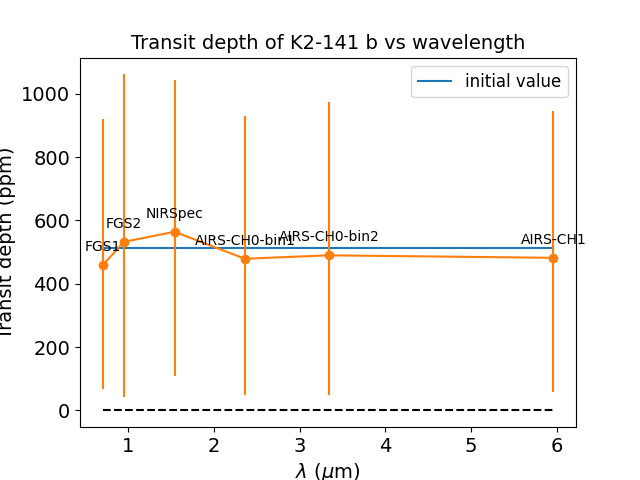

In [15]:
transit_depth = ((np.array(radii)/np.array(Radii_star))**2)*np.array(factor)
transit_depth_plus = 2*np.array(radii)*np.array(radii_plus)/(R_star)**2
transit_depth_minus = 2*np.array(radii)*np.array(radii_minus)/(R_star)**2 
transit_depth_plus_asy = ((( (np.array(radii)+np.array(radii_plus)) / (np.array(Radii_star)+np.array(Radii_star_plus)) )**2)*(np.array(factor)+np.array(factor_plus))) - ((np.array(radii)/np.array(Radii_star))**2)*(np.array(factor))
transit_depth_minus_asy =  ((np.array(radii)/np.array(Radii_star))**2)*(np.array(factor)) - ((((np.array(radii)-np.array(radii_minus))/(np.array(Radii_star)-np.array(Radii_star_minus)))**2)*(np.array(factor)-np.array(factor_minus)))

transit_yerr = np.vstack((transit_depth_minus, transit_depth_plus))
transit_yerr_asy = np.vstack((transit_depth_minus_asy, transit_depth_plus_asy))
print(transit_yerr_asy)
print(Radii_star)
print(Radii_star_minus)
print(((np.array(radii)/np.array(Radii_star))**2)*(np.array(factor)))
print(factor_minus)

plt.figure()
plt.plot(list(wvl), ((R/R_star)**2)*np.array(factor_init)*1e6, label='initial value')
plt.errorbar(list(wvl), transit_depth*1e6, transit_yerr_asy*1e6, fmt='-o')
plt.plot(list(wvl), 0*np.ones(len(instru)), 'k--')
for i, (x_val, y_val) in enumerate(zip(list(wvl), transit_depth*1e6)):
    plt.annotate(f'{str(instru[i])}',
                 (x_val, y_val),
                 textcoords="offset points",  # how to position the text
                 xytext=(0, 10),              # distance from the point
                 ha='center')                 # horizontal alignment
#plt.errorbar(wvl, transit_depth*1e6, transit_yerr_asy*1e6, fmt='-o', label='asymmetric error')
#plt.plot(wvl, (((np.array(radii)+np.array(radii_plus))/R_star)**2)*1e6)
plt.xlabel(r'$\lambda$ ($\mu$m)', fontsize=14)
plt.ylabel(r'Transit depth (ppm)', fontsize=14)
plt.title(r'Transit depth of K2-141 b vs wavelength', fontsize=14)
plt.legend(fontsize=12)
plt.savefig('transit_depth_K2-141b.svg')
plt.show()

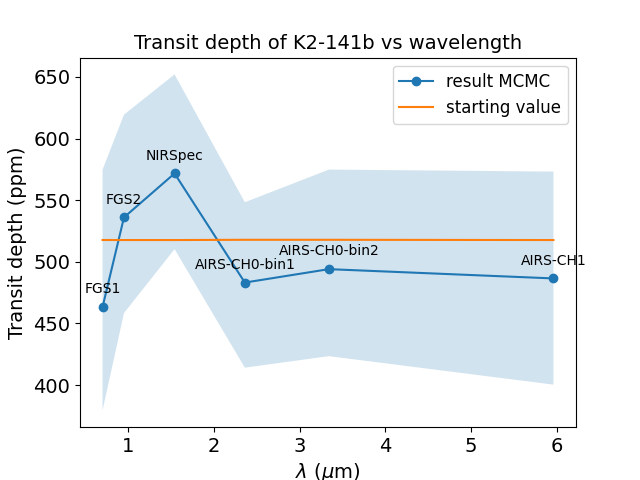

In [23]:
plt.figure()
#plt.plot(list(wvl), ((R/R_star)**2)*np.array(factor_init)*1e6, label='initial analytical')
plt.plot(list(wvl), np.array(transit_depths_jax)*1e6, '-o', label='result MCMC')
plt.plot(list(wvl), np.array(transit_depths_jax_init)*1e6, label='starting value')

plt.fill_between(list(wvl), np.array(transit_depths_jax_minus)*1e6, np.array(transit_depths_jax_plus)*1e6, alpha=0.2)
#plt.plot(list(wvl), 0*np.ones(len(instru)), 'k--')
for i, (x_val, y_val) in enumerate(zip(list(wvl), np.array(transit_depths_jax)*1e6)):
    plt.annotate(f'{str(instru[i])}',
                 (x_val, y_val),
                 textcoords="offset points",  # how to position the text
                 xytext=(0, 10),              # distance from the point
                 ha='center')                 # horizontal alignment
plt.xlabel(r'$\lambda$ ($\mu$m)', fontsize=14)
plt.ylabel(r'Transit depth (ppm)', fontsize=14)
plt.title(r'Transit depth of K2-141b vs wavelength', fontsize=14)
plt.legend(fontsize=12)
plt.savefig('transit_depth_K2-141b.svg')
plt.show()

In [16]:
import platon

from platon.eclipse_depth_calculator import EclipseDepthCalculator
from platon.TP_profile import Profile
from platon.abundance_getter import AbundanceGetter
from platon.constants import R_sun, AU, R_earth, M_earth

#Are you trying to generate emission spectra of an airless planet?
#Set Psurf=2e-4 (a very low value), set the atmospheric temperature to
#surface_temp with p.set_isothermal(surface_temp), and set the atmospheric
#composition to something with no features (e.g. abundances["N2"] += 1,
#after getting rid of the CO2 and CO).

#define system parameters
#T_star = 3600
#Rs = 0.4144 * R_sun
semi_major_axis = 0.00747 * AU
#Rp = 1.331 * R_earth
Mp = 4.97 * M_earth
Psurf = 2e-4 #1 bar
surface_library="Paragas" #Or Paragas
surface_types_Paragas = ["orlando_gold_granite_slab", "basaltic_andesite_slab",
                         "dalmatian_granite_slab",
                         "STM_101_andesite_slab", "new_basalt_slab", 
                         "EG_19_70_olivine_pyroxenite_slab", 
                         "EG_19_63_olivine_clinopyroxenite_slab", 
                         "EG_19_68_olivine_gabbronorite_slab", "hematite_crushed", 
                         "dunite_xenolith_crushed", "K1919_basalt_slab"]
#surface_temp = 1172.8

#define the gases and their respective VMRs to simulate the atmosphere
abundances = AbundanceGetter().get(0, 0.5)
for key in abundances:
    abundances[key] *= 0
#abundances["CO2"] += 0.01
#abundances["CO"] += 1 - 0.01
abundances["N2"] += 1

calc = EclipseDepthCalculator(surface_library=surface_library)
edges = np.arange(0.6, 6.1, 0.1) * 1e-6   # in meters
bins = np.column_stack((edges[:-1], edges[1:]))
calc.change_wavelength_bins(bins)

#define TP profile
p = Profile()
p.set_isothermal(T_planet)

for surface_type in surface_types_Paragas:
    wavelengths, depths, info_dict = calc.compute_depths(
        p, R_star, Mp, R, T_star, 
        logZ=None, CO_ratio=None, stellar_blackbody = False, 
        custom_abundances = abundances, 
        surface_pressure = Psurf,
        surface_type=surface_type, semimajor_axis=semi_major_axis, surface_temp = T_planet,
        full_output=True,
    )
    data = np.column_stack((wavelengths, depths))
    np.savetxt(f"Paragas_K2-141b_{surface_type}.txt", data, fmt="%.10f", delimiter="\t", 
               header="wavelength (um)\teclipse depth")

cupy not found. Disabling GPU acceleration


/home/localuser/Desktop/M2/LIU/Code/platon/platon/abundance_getter.py:27: RuntimeWarning: divide by zero encountered in log10
  self.log_abundances = xp.log10(xp.load(
/home/localuser/Desktop/M2/LIU/Code/platon/platon/_interpolator_3D.py:71: RuntimeWarning: invalid value encountered in multiply
  data[y_indices_upper, x_indices_lower]*y_indices_frac*(1-x_indices_frac) + \
/home/localuser/Desktop/M2/LIU/Code/platon/platon/_interpolator_3D.py:72: RuntimeWarning: invalid value encountered in multiply
  data[y_indices_lower, x_indices_upper]*(1-y_indices_frac)*x_indices_frac + \
/home/localuser/Desktop/M2/LIU/Code/platon/platon/_interpolator_3D.py:73: RuntimeWarning: invalid value encountered in multiply
  data[y_indices_upper, x_indices_upper]*y_indices_frac*x_indices_frac


In [17]:
"""#plot model 
f, ax = plt.subplots(1, 1, figsize = (5,4), constrained_layout = True)
#ax.plot(unbinned_wavelengths * 1e6, unbinned_depths*1e6, color = 'cornflowerblue', zorder = 1, label = 'unbinned depths')
for i in range(len(wvl_HES2012)):
    ax.plot(wvl_HES2012[i] * 1e6, depths_HES2012[i] * 1e6, zorder = 1000, label = surface_types_HES2012[i])
ax.set_xlabel('wavelength [um]')
ax.set_ylabel('depth [ppm]')
ax.legend()
plt.show()
#plt.close()"""

"#plot model \nf, ax = plt.subplots(1, 1, figsize = (5,4), constrained_layout = True)\n#ax.plot(unbinned_wavelengths * 1e6, unbinned_depths*1e6, color = 'cornflowerblue', zorder = 1, label = 'unbinned depths')\nfor i in range(len(wvl_HES2012)):\n    ax.plot(wvl_HES2012[i] * 1e6, depths_HES2012[i] * 1e6, zorder = 1000, label = surface_types_HES2012[i])\nax.set_xlabel('wavelength [um]')\nax.set_ylabel('depth [ppm]')\nax.legend()\nplt.show()\n#plt.close()"

dict_keys([np.float64(0.7), np.float64(0.95), np.float64(1.54), np.float64(2.36), np.float64(3.34), np.float64(5.96)])
['FGS1', 'FGS2', 'NIRSpec', 'AIRS-CH0-bin1', 'AIRS-CH0-bin2', 'AIRS-CH1']
[Array(1.51285867e-05, dtype=float64), Array(3.72065057e-05, dtype=float64), Array(9.35672078e-05, dtype=float64), Array(0.00014701, dtype=float64), Array(0.00016815, dtype=float64), Array(0.00020218, dtype=float64)]
[Array(7.54622853e-06, dtype=float64), Array(1.5364732e-05, dtype=float64), Array(7.95275779e-06, dtype=float64), Array(2.42891359e-05, dtype=float64), Array(1.92420777e-05, dtype=float64), Array(2.27695858e-05, dtype=float64)]
[Array(1.25322871e-05, dtype=float64), Array(1.73582542e-05, dtype=float64), Array(7.89125951e-06, dtype=float64), Array(2.36635955e-05, dtype=float64), Array(2.07409682e-05, dtype=float64), Array(1.17142219e-05, dtype=float64)]
[Array(1.16495222e+11, dtype=float64), Array(1.44305251e+11, dtype=float64), Array(2.79408158e+10, dtype=float64), Array(2.23875145e+

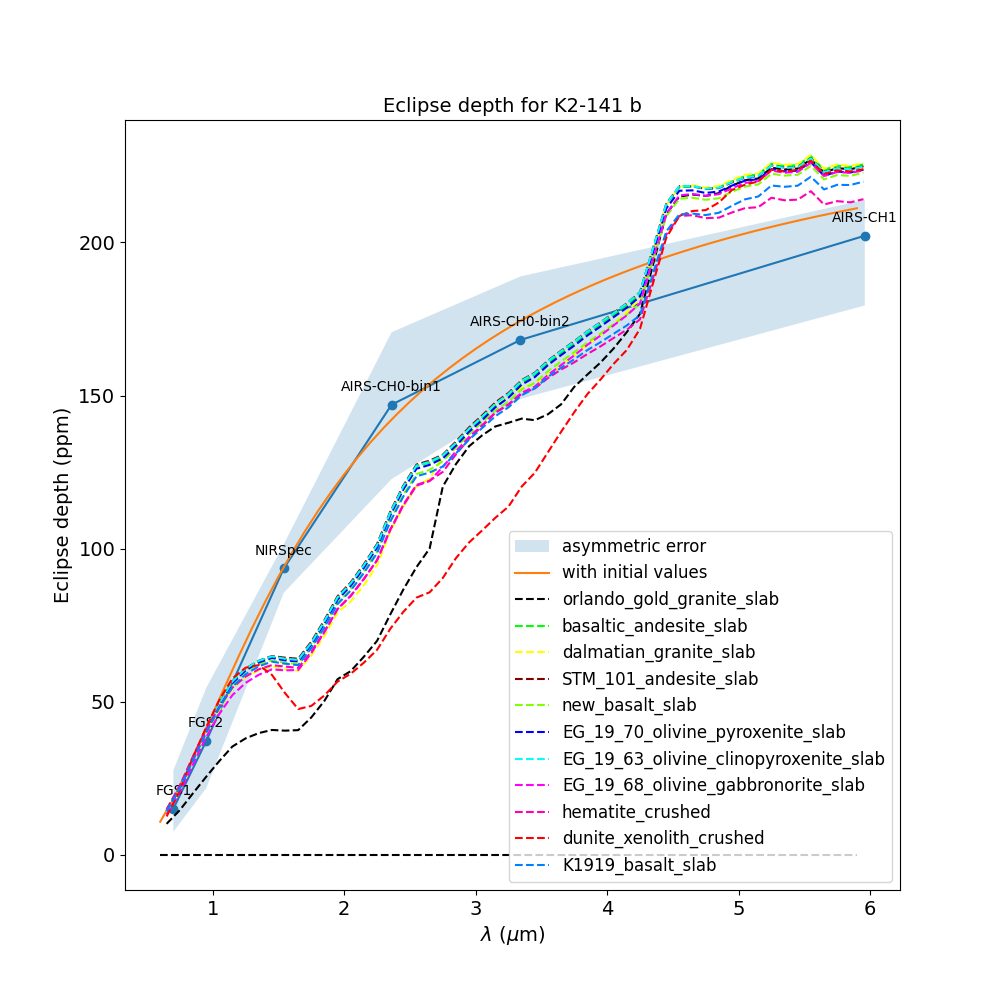

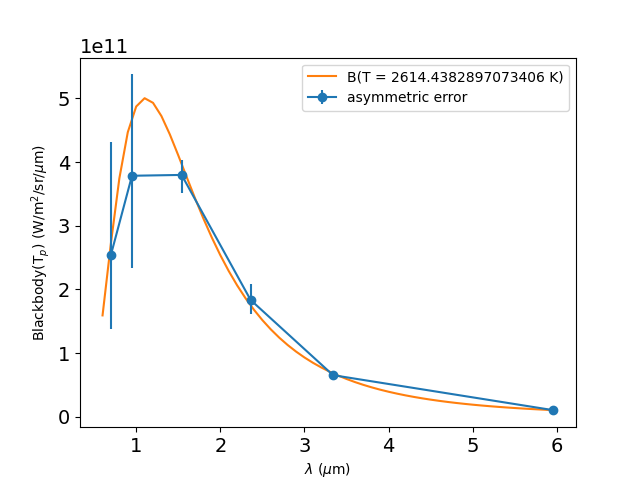

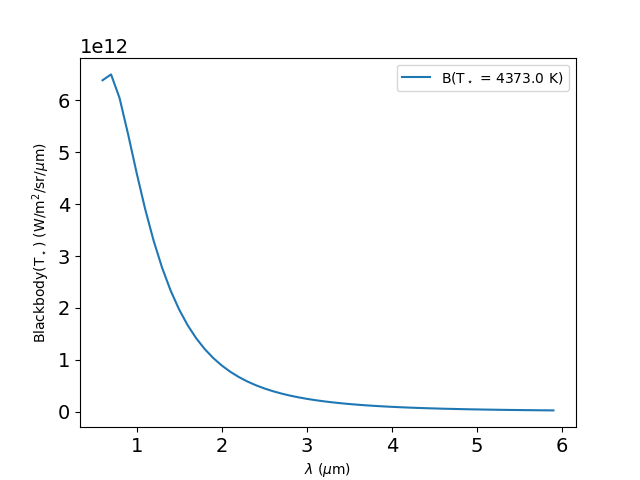

In [18]:
planet_fluxes = []
planet_fluxes_plus = []
planet_fluxes_minus = []
star_fluxes = []
eclipse_depths = []
eclipse_depths_plus = []
eclipse_depths_minus = []
planet_fluxes_minus_symm = []
planet_fluxes_plus_symm = []
eclipse_depths_minus_symm = []
eclipse_depths_plus_symm = []
colors = [(0,0,0), (0,1,0), (1,1,0), (.5,0,0), (.5,1,0), (0,0,1), (0,1,1), (1,0,1), (1,0,.7), 
          (1,0,0), (0,.5,1)]

def dB_dT(lam, T):
    x = h*c/(lam*kB*T)
    return (2*h*c**2/lam**5) * (x*np.exp(x)) / (T*(np.exp(x)-1)**2)

for i in range(len(wvl)):
    T50 = Temps[i]
    T16 = Temps[i] - Temps_minus[i]
    T84 = Temps[i] + Temps_plus[i]
    Tstar50 = Temps_star[i]
    Tstar16 = Temps_star[i] - Temps_star_minus[i]
    Tstar84 = Temps_star[i] + Temps_star_plus[i]
    B50 = planck(list(wvl)[i]*1e-6, T50)
    B16 = planck(list(wvl)[i]*1e-6, T16)
    B84 = planck(list(wvl)[i]*1e-6, T84)
    Bstar50 = planck(list(wvl)[i]*1e-6, Tstar50)
    Bstar16 = planck(list(wvl)[i]*1e-6, Tstar16)
    Bstar84 = planck(list(wvl)[i]*1e-6, Tstar84)
    R50 = radii[i]
    R16 = radii[i] - radii_minus[i]
    R84 = radii[i] + radii_plus[i]
    Rstar50 = Radii_star[i]
    Rstar16 = Radii_star[i] - Radii_star_minus[i]
    Rstar84 = Radii_star[i] + Radii_star_plus[i]
    planet_fluxes.append(B50)
    #planet_fluxes_minus_symm.append(dB_dT(list(wvl)[i]*1e-6, Temps[i])*Temps_minus[i])
    #planet_fluxes_plus_symm.append(dB_dT(list(wvl)[i]*1e-6, Temps[i])*Temps_plus[i])
    planet_fluxes_minus.append(B50 - B16)
    planet_fluxes_plus.append(B84 - B50)
    #star_fluxes.append(planck(list(wvl)[i]*1e-6, T_star))
    depth50 = (B50/Bstar50)*(R50/Rstar50)**2
    depth16 = (B16/Bstar16)*(R16/Rstar16)**2
    depth84 = (B84/Bstar84)*(R84/Rstar84)**2
    eclipse_depths.append(depth50)
    #cst = 1/(star_fluxes[i]*R_star**2)
    #eclipse_depths_minus_symm.append(np.sqrt((cst*(radii[i]**2)*planet_fluxes_minus_symm[i])**2 + (2*cst*planet_fluxes[i]*radii[i]*radii_minus[i])**2))
    #eclipse_depths_plus_symm.append(np.sqrt((cst*(radii[i]**2)*planet_fluxes_plus_symm[i])**2 + (2*cst*planet_fluxes[i]*radii[i]*radii_plus[i])**2))
    eclipse_depths_minus.append(depth50 - depth16)
    eclipse_depths_plus.append(depth84 - depth50)

print(wvl)
print(instru)
print(eclipse_depths)
print(eclipse_depths_minus)
print(eclipse_depths_plus)
print(planet_fluxes_minus)
print(planet_fluxes_plus)
depth_yerr = np.vstack((eclipse_depths_minus, eclipse_depths_plus))
#depth_yerr_symm = np.vstack((eclipse_depths_minus_symm, eclipse_depths_plus_symm))
#depth_yerr_2 = np.vstack((eclipse_minus_2, eclipse_plus_2))

wvl_array = np.arange(0.6, 6, 0.1)
plt.figure(figsize = (10,10))
#plt.errorbar(wvl, np.array(eclipse_depths)*1e6, np.array(depth_yerr)*1e6, fmt='-o', label='asymmetric error')
#plt.errorbar(wvl, np.array(eclipse_depths)*1e6, np.array(depth_yerr_symm)*1e6, fmt='--o', label='symmetric error')
#plt.errorbar(wvl, np.array(eclipse_depths_2)*1e6, np.array(depth_yerr_2)*1e6, fmt='-o', label='from MCMC')
plt.plot(wvl, np.array(eclipse_depths)*1e6, '-o')
#plt.fill_between(wvl, (np.array(eclipse_depths) - np.array(eclipse_depths_minus_symm)/np.sqrt(3))*1e6, (np.array(eclipse_depths) + np.array(eclipse_depths_plus_symm)/np.sqrt(3))*1e6, alpha=0.2, label='symmetric error')
plt.fill_between(wvl, (np.array(eclipse_depths) - np.array(eclipse_depths_minus))*1e6, (np.array(eclipse_depths) + np.array(eclipse_depths_plus))*1e6, alpha=0.2, label='asymmetric error')
plt.plot(wvl_array, ((planck(wvl_array*1e-6, T_planet)/planck(wvl_array*1e-6, T_star))*(R/R_star)**2)*1e6, label='with initial values')
plt.plot(wvl_array, 0*np.ones(len(wvl_array)), 'k--')
for i in range(len(surface_types_Paragas)):
    data = np.loadtxt(f"Paragas_K2-141b_{surface_types_Paragas[i]}.txt")
    plt.plot(data[:,0] * 1e6, data[:,1] * 1e6, '--', c = colors[i], zorder = 1000, 
             label = surface_types_Paragas[i])
for i, (x_val, y_val) in enumerate(zip(wvl, np.array(eclipse_depths)*1e6)):
    plt.annotate(f'{str(instru[i])}',
                 (x_val, y_val),
                 textcoords="offset points",  # how to position the text
                 xytext=(0, 10),              # distance from the point
                 ha='center')                 # horizontal alignment
plt.xlabel(r'$\lambda$ ($\mu$m)', fontsize=14)
plt.ylabel(r'Eclipse depth (ppm)', fontsize=14)
plt.title(r'Eclipse depth for K2-141 b', fontsize=14)
plt.legend(fontsize=12, loc='lower right')
plt.savefig('eclipse_depth_K2-141b_Paragas.svg')
plt.show()

plt.figure()
plt.errorbar(wvl, np.array(planet_fluxes), np.vstack((planet_fluxes_minus, planet_fluxes_plus)), fmt='-o', label='asymmetric error', zorder=3)
#plt.errorbar(wvl, np.array(planet_fluxes), np.vstack((planet_fluxes_minus_symm, planet_fluxes_plus_symm)), fmt='-o', label='symmetric error')
plt.plot(wvl_array, planck(wvl_array*1e-6, T_planet), label=f'B(T = {T_planet} K)')
plt.xlabel(r'$\lambda$ ($\mu$m)')
plt.ylabel(r'Blackbody(T$_p$) (W/m$^2$/sr/$\mu$m)')
plt.legend()
plt.show()

plt.figure()
plt.plot(wvl_array, planck(wvl_array*1e-6, T_star), label=fr'B(T$_\star$ = {T_star} K)')
plt.xlabel(r'$\lambda$ ($\mu$m)')
plt.ylabel(r'Blackbody(T$_\star$) (W/m$^2$/sr/$\mu$m)')
plt.legend()
plt.show()

In [19]:
2.898*1e-3/T_planet
2.898*1e-3/T_star

np.float64(6.627029499199635e-07)

In [20]:
0.01*const.R_sun/const.R_earth

<Quantity 1.09076371>

In [21]:
"""import pysynphot as S
from scipy import interpolate

# LHS-1140:
Teff_LHS1140 = 3096 
Fe_H_LHS1140 = -0.15 
logg_LHS1140 = 5.041
Jmag_LHS1140 = 9.612
name_LHS1140 = 'LHS 1140'

star = S.Icat('phoenix', Teff, Fe_H, logg)  # Phoenix model
star_mJy  = star.renorm(Jmag, 'vegamag', S.ObsBandpass('johnson,j'))
star_mJy.convert('Micron')
star_mJy.convert('mjy')  # convert flux to mJy for JWST ETC input,
 
t = np.linspace(1,19,2000)
x_model_phoenix = star_mJy.wave
y_model_phoenix = star_mJy.flux
f_model_phoenix = interpolate.interp1d(x_model_phoenix,y_model_phoenix ) 
plt.plot(t, f_model_phoenix(t), alpha=0.6,label=name, color=color, linewidth=3)"""

"import pysynphot as S\nfrom scipy import interpolate\n\n# LHS-1140:\nTeff_LHS1140 = 3096 \nFe_H_LHS1140 = -0.15 \nlogg_LHS1140 = 5.041\nJmag_LHS1140 = 9.612\nname_LHS1140 = 'LHS 1140'\n\nstar = S.Icat('phoenix', Teff, Fe_H, logg)  # Phoenix model\nstar_mJy  = star.renorm(Jmag, 'vegamag', S.ObsBandpass('johnson,j'))\nstar_mJy.convert('Micron')\nstar_mJy.convert('mjy')  # convert flux to mJy for JWST ETC input,\n\nt = np.linspace(1,19,2000)\nx_model_phoenix = star_mJy.wave\ny_model_phoenix = star_mJy.flux\nf_model_phoenix = interpolate.interp1d(x_model_phoenix,y_model_phoenix ) \nplt.plot(t, f_model_phoenix(t), alpha=0.6,label=name, color=color, linewidth=3)"